In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as scp
import nltk
import imageio
import sklearn

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.svm import SVR
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

from timeit import default_timer as timer
%matplotlib inline

import json as js

# Project
### Stages

**Timetable**

| Time | Task |
|----|----|
|9.9. | Groups deadline |
|16.9.| Topics deadline |
| here | EDA, clean data, do project |
|vk42 | presentation |
|vk43 | projektit |

## Project
```
A. Title of the project	
            
B. Elevator pitch [max 400 characters]
 
Describe the data science challenges related to the following themes. 
A good project should include interesting challenges under most of 
the themes. So for example, a project that begins with a single clean
data set and a clear task (e.g., predict a given response), isn't a good 
choice for your project.		
            
C. Data: sources, wrangling, management		
            
D. Data analysis: statistics, machine learning	
            
E. Communication of results: summarization & visualization
            
F. Operationalization: creating added value, end-user point of view
```

- 4x20x10000 stuctures with 19-30 atoms in a cluster
    - coordinates
    - dipole moment
    - energy
- Goals
    - End user
        - Configuration Sampling 
            - Find one structure with the lowest energy
    - Eliminate redundant structures
    - Find descriptors
        - reduce dimensions
    

## Pitch talk 3min

- Sell oriented
    - Not technical
- Slides, picures, figures
    - Why useful
    - Why interesting
- Any person or all

> We could make video from screenshots describing the problem

> Check project-instructions for deadlines (tue 22.10. klo 23.59)

# How to Cluster

#### Read data in

Data must have a `.csv`-file that contains:  
Header row: ``` Filename,LogPath,XYZPath,Dipole,Energy ```


| Filename | LogPath | XYZPath | Dipole| Energy |
|------|------|------|------|------|
| Name of the cluster | path to .log-file | path to .xyz-file | Dipole moment value | Energy value |

> Here we either require the .log-file or remove it from the code

#### Make the csv-file 
> Instructions how to make the .csv-file from the actual data using the script

#### Run these cells with ```shift+enter```

In [2]:
def init_DF(csvfile):
    "Reads a xyz-file and initializes the dataframe."
    
    filescsv = pd.read_csv(csvfile)                    # Read tthe .csv-file to a DataFrame
    xyz_temp = filescsv.iloc[0,2]                      # Get one .xyz-file as a reference
    
    xyz_test = read_xyz(xyz_temp,flatten=False)        # Read coordinates to a DF (no flattening)
    
    #filenames = filescsv.iloc[:,0]                    # Get the names for files as a Series (This one not used here)
    n_atoms = xyz_test.index.size                      # Number of atoms from the reference .xyz-file
    atomnames = np.array(xyz_test.index)               # Names of all the atoms as ndarray
    
    list_atomnames = []
    for i,j in enumerate(atomnames):                   # Give numbers for the atoms
        list_atomnames.append("{}_{}".format(j,i))
    arr_atomnames = np.array(list_atomnames)           # Enumerated atomnames as an ndarray
    
    col_names = makeMultiIndexs(arr_atomnames)         # Make column names (multi-index)

    arr_clusters,filenames = init_xyz_array(filescsv,n_atoms) # Read the actual coordinate data
    
    coord_df = pd.DataFrame(arr_clusters,index=filenames,columns=col_names) # Save the data in nice DF-fornat
    
    
    return coord_df

In [3]:
def init_xyz_array(filecsv, n_atoms):
    """Reads .xyz-file paths from .csv-file and returns 
    an array with all xyz-coords in rows, and the filenames for DF indexes"""
    
    arr_clusters = np.zeros((1,3*n_atoms+2))             # cols of coord array should be of shape [clusters,atoms*[x,y,z]]
    filenames = np.array(filecsv.Filename)               # Get the names of the clusters from the .csv-file

    for index, row in filecsv.iterrows():                # Iterate through clusters and save their attributes
        dipole = row.Dipole                              # find the dipole value
        energy = row.Energy                              # find the energy value
        metarr = np.array([energy,dipole])               # put dipole and energy to an array
        path = row.XYZPath                               # find the path for .xyz-file
        xyzs = read_xyz(path)                            # Read coordinates to an ndarray with flatten=True (default)

        #if index == None:                               # print stuff for debugging purposes of this function
        #    print("Filename:",filename)
        #    print("metarr:",metarr)
        #    print("shape:",metarr.shape)
        #    print("type:",type(metarr))
        #    print("path:",path)
        #    print("coordshape:",xyzs.shape)
        #    print("coords:",xyzs)
        
        arrr = np.array(list(metarr)+list(xyzs))         # concatenate one cluster info
        arr_clusters = np.vstack((arr_clusters,arrr))    # concatenate clusters to one array
    return arr_clusters[1:,:], filenames

In [4]:
def read_xyz(xyzfile,flatten=True):
    """
    usage: read_xyz(xyzfile,flatten(Default=True))
    
    Reads a xyz-file and returns the coordinates as DF
    or flattened to a Numpy-array
    """
    xyz_temp = pd.read_csv(xyzfile, \
                       sep='\s+', \
                       skiprows=2, \
                       header=None, \
                       index_col=0, \
                       names=['x','y','z']\
                      ).sort_index(ascending=False)       # Reads coordinates from an xyz-file
    
    atoms3 = xyz_temp.shape[0]*3                          # multiply n of atoms with 3 dimensions
    
    if flatten==True:
        xyz_flat = xyz_temp.values.flatten().reshape(1,atoms3)#.astype(np.float)
        return xyz_flat[0]                                # returns coordinates as ndarray of shape [1,atoms*3]
    else:
        return xyz_temp                                   # returns coordinates as a DF

In [5]:
def makeMultiIndexs(arr):
    """
    Gets names of atoms as array and makes a pandas multi-indexing structure
    with x-, y- and z- columns for each atom.
    """
    top_arr = np.empty((arr.size * 3 +2)).astype(str)
    top_arr[0] = "Properties"
    top_arr[1] = "Properties"
    top_arr[2::3] = arr
    top_arr[3::3] = arr
    top_arr[4::3] = arr
    butt_arr = np.empty((arr.size * 3 +2)).astype(str)
    butt_arr[0] = "Energy"
    butt_arr[1] = "Dipole"
    butt_arr[2::3] = "x"
    butt_arr[3::3] = "y"
    butt_arr[4::3] = "z"
    col_arr = np.vstack((top_arr,butt_arr))
    #col_arr.transpose()
    col_arr_tuples = list(zip(*col_arr))
    col_names = pd.MultiIndex.from_tuples(col_arr_tuples, names=["Atom","Coord"])
    return col_names

In [6]:
clusters_df = init_DF("Data2/Data_Collection.csv")

In [7]:
#from multi-index to one index
clusters_df.columns = ['_'.join(col) for col in clusters_df.columns.values]

In [8]:
clusters_df.shape

(46000, 80)

## Data exploration / EDA

We start by looking at the correlation among our variables. The correlation betwwen two variables is a measure of the linear dependecy among them:
$$ Cor(X,Y)=\frac{Cov(X,Y)}{\sqrt{Var(X)Var(Y)}}$$
In order to apply a linear model to predict the energy wrt the other variables, is important to check that there is a small correlation  between the variables we are using as predictors, since we will predict the response by an approprate linear combination of the predictors. In our data, there is no particoularly high correlation.

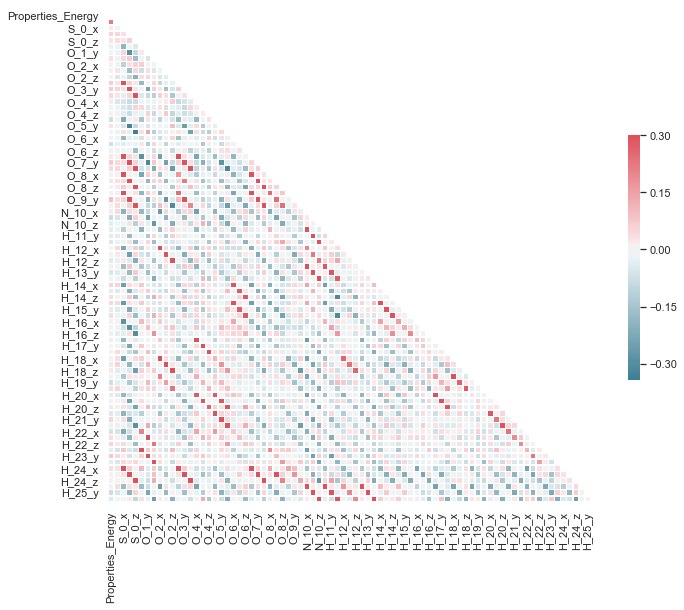

In [9]:
sns.set(style="white")

# Compute the correlation matrix
corr = clusters_df.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11,9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

The correlations among data are not really high, hence we can consider all of hem as independent variables.   
Having a look on the distributions of the energy variable, it is asymmetric, with a tail on the right. 

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


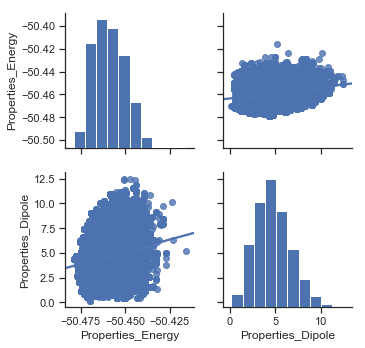

In [10]:
sns.set(style="ticks", color_codes=True)
sns.pairplot(clusters_df,  kind="reg",vars=['Properties_Energy','Properties_Dipole'])

Energy and dipole don't have significant correlation

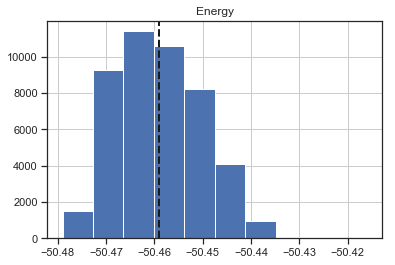

In [11]:
clusters_df['Properties_Energy'].hist()
plt.title("Energy")
plt.axvline(np.mean(clusters_df['Properties_Energy']), color='k', linestyle='dashed', linewidth=2)

Difference between min and max energies is very small

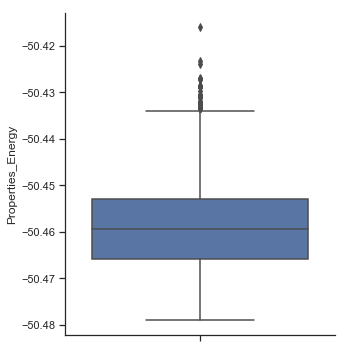

In [12]:
sns.catplot( y="Properties_Energy", kind="box", data=clusters_df)

The algorithm in ABCluster tries to make the energies as small as possible hich can be seen here

In [13]:
clusters_df.head(5)

,Properties_Energy,Properties_Dipole,S_0_x,S_0_y,S_0_z,O_1_x,O_1_y,O_1_z,O_2_x,O_2_y,...,H_22_z,H_23_x,H_23_y,H_23_z,H_24_x,H_24_y,H_24_z,H_25_x,H_25_y,H_25_z
0,-50.468145,4.356,-1.379895,0.061807,-0.182111,0.833224,-2.280608,1.259301,-0.682875,0.984043,...,-0.509070,0.255694,-1.867411,0.572017,0.584763,-3.206009,1.292245,1.863612,2.127057,-1.606021
10000,-50.457607,2.750,0.798500,0.836092,0.827934,-0.154249,-2.626647,1.372386,-2.453504,-0.806170,...,1.891598,0.033223,-1.684598,1.578384,1.966529,2.451897,0.970348,2.605926,1.759835,-0.742523
10001,-50.465552,6.214,-0.288598,-2.171093,0.563159,-0.632725,0.717265,2.203356,1.180794,1.990274,...,3.153432,-0.708250,-0.272533,2.054326,0.037828,-4.056000,1.075719,-0.734545,2.556864,-2.136832
10002,-50.465552,6.213,1.626512,1.411786,0.689068,-2.189124,0.004796,-1.029754,-1.640830,1.150459,...,-0.190639,-2.982469,0.418140,-1.372406,2.966937,2.867822,0.762887,-1.451448,-1.608632,-0.716312
10003,-50.461850,4.325,-0.135050,1.694351,-0.653021,1.417901,-1.183480,0.336841,-0.964465,-1.903038,...,-0.255785,1.600258,-0.796789,1.236348,0.862813,3.382070,-1.040802,1.089250,0.964558,2.143423


In [14]:
energy=clusters_df['Properties_Energy'] # %1 should take only the decimals but does it?
coord=clusters_df.drop(['Properties_Energy','Properties_Dipole'],1) # dipoles and energy out

In [15]:
energy.head()

0       -50.468145
10000   -50.457607
10001   -50.465552
10002   -50.465552
10003   -50.461850
Name: Properties_Energy, dtype: float64

In [16]:
coord.head()

,S_0_x,S_0_y,S_0_z,O_1_x,O_1_y,O_1_z,O_2_x,O_2_y,O_2_z,O_3_x,...,H_22_z,H_23_x,H_23_y,H_23_z,H_24_x,H_24_y,H_24_z,H_25_x,H_25_y,H_25_z
0,-1.379895,0.061807,-0.182111,0.833224,-2.280608,1.259301,-0.682875,0.984043,-3.337186,-2.308828,...,-0.509070,0.255694,-1.867411,0.572017,0.584763,-3.206009,1.292245,1.863612,2.127057,-1.606021
10000,0.798500,0.836092,0.827934,-0.154249,-2.626647,1.372386,-2.453504,-0.806170,1.581223,1.814587,...,1.891598,0.033223,-1.684598,1.578384,1.966529,2.451897,0.970348,2.605926,1.759835,-0.742523
10001,-0.288598,-2.171093,0.563159,-0.632725,0.717265,2.203356,1.180794,1.990274,0.705587,1.145537,...,3.153432,-0.708250,-0.272533,2.054326,0.037828,-4.056000,1.075719,-0.734545,2.556864,-2.136832
10002,1.626512,1.411786,0.689068,-2.189124,0.004796,-1.029754,-1.640830,1.150459,1.323925,1.291682,...,-0.190639,-2.982469,0.418140,-1.372406,2.966937,2.867822,0.762887,-1.451448,-1.608632,-0.716312
10003,-0.135050,1.694351,-0.653021,1.417901,-1.183480,0.336841,-0.964465,-1.903038,0.512459,0.049028,...,-0.255785,1.600258,-0.796789,1.236348,0.862813,3.382070,-1.040802,1.089250,0.964558,2.143423


## Linear regression

In statistics we define as "supervised learning" the set of models that are ment to evaluate an output $y$ (answer variable) as a function of a set of known indipendent variables taken as input $(X_1,...,X_k)$ .   
Furthermore, if we assume that $Y$ has a known probability law, we use parametric models. When $Y$ is a continuous variable, the mainly used model is the regression, that is a method that allows to estimate the conditional average of the answer $ E (Y | X_1 = x_1, ..., X_k = x_k) $ or its transformed as a linear combination of the explanatory $\eta=X '\beta $.
We have a simple linear regression, when using a model of the type:
$$ Y_i = x_i '\beta + \varepsilon_i $$ with $i = 1, ..., n $ number of observations, such that $ n> k $. Equivalently, in compact form:
$$ Y = X \beta + \varepsilon $$ where $ Y_ {nx1} = (Y_1, ..., Y_n) '$ is the vector of n v.c. of independent outputs, $ X_ {nx (k + 1)} $ is the matrix of the drawing, which together with the vector of coefficients $ \beta = (\beta_0, ..., \beta_k) '$ constitutes the deterministic component of the model, while $ \varepsilon = (\varepsilon_1, ..., \varepsilon_n) '$ is the erratic component, where $ \varepsilon_i \sim N (0, \sigma ^ 2 _ {\varepsilon}) $ for each $ i $ are unknown errors with zero mean and constant variance.

We can implement a linear regression model to predict the energy ($y$) of our cluster with rrespect to the coordinates variables ($X$). As we saw above, our response takes all values around -40.9, what makes the difference is the centesimal portion, hence we will focus our attention on predicting this part.


In [17]:
#divide the dataset in train and test

x_train,x_test,y_train,y_test = train_test_split(coord,energy,test_size=0.20)

In [18]:
#linear regression model on train set

model = LinearRegression()
model.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [19]:
#model.coeff
r_sq = model.score(x_train, y_train)
r_sq #pretty bad

0.06846450429807327

In [20]:
#predict from the test
y_pred = model.predict(x_test)
pred_test = pd.DataFrame({'Actual': y_test.values.flatten(), 'Predicted': y_pred.flatten()})
pred_test.head(6)

,Actual,Predicted
0,-50.472017,-50.459624
1,-50.454509,-50.458711
2,-50.446396,-50.462659
3,-50.463613,-50.460996
4,-50.452341,-50.457270
5,-50.453164,-50.458632


In [21]:
#divide the dataset in train and test

coord_train,coord_test,energy_train,energy_test = train_test_split(coord,energy,test_size=0.20)

In [22]:
#linear regression model on train set

model = LinearRegression()
model.fit(coord_train, energy_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [23]:
#model.coeff
r_sq = model.score(coord_train, energy_train)
r_sq #pretty bad

0.06640416294940787

Linear regression works poorly which means that the conformation in general doesn't correlate with the energy

In [24]:
#predict from the test
energy_pred = model.predict(coord_test)
predictions = pd.DataFrame({'Actual': energy_test.values.flatten(), 'Predicted': energy_pred.flatten()})
predictions.head(6)

,Actual,Predicted
0,-50.473921,-50.463166
1,-50.450647,-50.457226
2,-50.458822,-50.458865
3,-50.467751,-50.462950
4,-50.465465,-50.462234
5,-50.458998,-50.459540


### Linear Regression with Feature selection

In [25]:
#feature selection alternative
#https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html

estimator = SVR(kernel="linear")
selector = RFE(estimator, 5, step=1)
selector = selector.fit(coord_train, energy_train)
#print(selector.support_) 
print(selector.ranking_)

[74 73 72 71 70 69 68 67 66 65 64 63 62 61 60 59 58 57 56 55 54 53 52 51
 50 49 48 47 46 45 44 43 42 41 40 39 38 37 36 35 34 33 32 31 30 29 28 27
 26 25 24 23 22 21 20 19 18 17 16 15 14 13 12 11 10  9  8  7  6  5  4  3
  2  1  1  1  1  1]


> But what is this then selecting?

In [26]:
coord_train.columns

Index(['S_0_x', 'S_0_y', 'S_0_z', 'O_1_x', 'O_1_y', 'O_1_z', 'O_2_x', 'O_2_y',
       'O_2_z', 'O_3_x', 'O_3_y', 'O_3_z', 'O_4_x', 'O_4_y', 'O_4_z', 'O_5_x',
       'O_5_y', 'O_5_z', 'O_6_x', 'O_6_y', 'O_6_z', 'O_7_x', 'O_7_y', 'O_7_z',
       'O_8_x', 'O_8_y', 'O_8_z', 'O_9_x', 'O_9_y', 'O_9_z', 'N_10_x',
       'N_10_y', 'N_10_z', 'H_11_x', 'H_11_y', 'H_11_z', 'H_12_x', 'H_12_y',
       'H_12_z', 'H_13_x', 'H_13_y', 'H_13_z', 'H_14_x', 'H_14_y', 'H_14_z',
       'H_15_x', 'H_15_y', 'H_15_z', 'H_16_x', 'H_16_y', 'H_16_z', 'H_17_x',
       'H_17_y', 'H_17_z', 'H_18_x', 'H_18_y', 'H_18_z', 'H_19_x', 'H_19_y',
       'H_19_z', 'H_20_x', 'H_20_y', 'H_20_z', 'H_21_x', 'H_21_y', 'H_21_z',
       'H_22_x', 'H_22_y', 'H_22_z', 'H_23_x', 'H_23_y', 'H_23_z', 'H_24_x',
       'H_24_y', 'H_24_z', 'H_25_x', 'H_25_y', 'H_25_z'],
      dtype='object')

With only 2 hydrogens the $R^2$ value is smaller than with all the atoms

In [27]:
#oxigen O8 seems the most significant variable in our model
model1 = LinearRegression().fit(x_train.loc[:,('H_17_x','H_17_y','H_17_z','H_18_x','H_18_y','H_18_z')], y_train) #select the most significant variables...
print('R2 simple reg',model1.score(x_train.loc[:,('H_17_x','H_17_y','H_17_z','H_18_x','H_18_y','H_18_z')], y_train))

R2 simple reg 0.0016082195750102282


With all the other atoms than hydrogens:

In [28]:
coord_train.iloc[:5,:33]

,S_0_x,S_0_y,S_0_z,O_1_x,O_1_y,O_1_z,O_2_x,O_2_y,O_2_z,O_3_x,...,O_7_z,O_8_x,O_8_y,O_8_z,O_9_x,O_9_y,O_9_z,N_10_x,N_10_y,N_10_z
5088,0.677791,-0.767955,-0.733395,-2.199339,0.393248,-2.211429,-0.982092,-1.848287,-3.108313,1.790192,...,-0.489886,1.237853,-0.924508,-2.168354,-0.075812,0.495852,-0.681277,-1.510320,-0.641242,1.390416
6266,1.486766,-0.847170,-0.857376,3.176639,1.306052,0.618502,-1.922616,-1.400649,1.045455,2.880520,...,-1.025236,-1.592929,1.170634,1.511297,0.728658,-1.236378,0.473850,-1.234978,1.157835,-1.165974
37225,1.039163,-1.589517,-1.051010,-0.406220,-1.682465,1.700306,-1.967210,0.544208,-1.672820,1.624091,...,-2.348505,1.290425,-2.600926,-0.051204,-0.344303,-1.451223,-1.442080,0.258020,1.938708,-0.968106
24278,0.359199,0.077300,-1.954605,1.408683,-1.373938,0.918048,2.709434,1.032116,0.323640,1.439467,...,-0.735501,0.924407,-1.308985,-1.573826,-0.494144,-0.103063,-3.079032,-1.872734,0.933436,1.925075
28973,1.535472,-0.785809,1.338807,0.556720,-2.165580,-1.624806,1.006919,0.360857,-2.820501,0.145160,...,2.020687,1.742918,-0.388009,-0.171362,2.481545,-1.771813,1.709490,-2.110061,0.619749,2.576131


In [29]:
# omit hydrogens
model2 = LinearRegression().fit(coord_train.iloc[:,:33], energy_train) #select the most significant variables...
print('R2 simple reg',model2.score(coord_train.iloc[:,:33], energy_train))

R2 simple reg 0.03813448752034032


## Principal Component Analysis
The PCA is a tool used to reduce the dimensionality of the data.
It tries to preserve as much information as possible.  
These two goals in PCA are pursued by means of a transformation of the original variables into new variables, called Principal Components (PCs).  
They consists of a linear combination of the original variables.
PCs are uncorrelated and arranged in order of decreasing variance, so that the first PCs account for most of the variation in the sample.   

Assuming we want to reduce the number of our original p variables to $k<p$ variables, the PCA method can be formalized as follows:  
• 1st PC: determine the coeffcients of the linear combination
$$Z_{1j} = a_1^T X = \sum_{i=0}^p a_{1i} X_i $$ 
that maximize $ Var(Z_1) = a_1^T \Sigma a_1 $ under the constraint $ a_1^T a_1 = 1 $   

> The formula $ Var(Z_1) = a_1^T \Sigma a_1 $ looks weird

• 2nd PC: determine coeffcients of the linear combination
$$ Z_{2j} = a_2^T X = \sum_{i=0}^p a_{2i} X_i $$
that maximize $ Var(Z_2) = a_2^T \Sigma a_2$ under the constraint $ a_2^T a_2=1$ and $Cov(Z_1,Z_2)=0$   

• proceed in a similar fashion for all other components.   

• Final output: $Z_1, \dots ,Z_p $such that $Var (Z1) > Var (Z2) > \dots > Var (Zp)$ and $cov(Zj ; Zk ) = 0$ for $j \neq k$  

We will apply PCA to our coordinates variable, in order to select new variables, that explain at least 80% of the variability of our data.

In [30]:
pca = PCA(n_components=0.8,svd_solver='full')   # from docstring: this should include PCs so that 80% of variance is explained
PCs_coord = pca.fit_transform(coord)
PCs_df = pd.DataFrame(data = PCs_coord, columns=["PC{}".format(i) for i in range(PCs_coord.shape[1])])
print('Explained variance :', np.sum(pca.explained_variance_ratio_)*100, '%')    # It seems that it is 80% :D

Explained variance : 80.21909698485126 %


Explained variance PC1 : 5.7587319555172645 %
Explained variance PC2 : 5.449759951285687 %


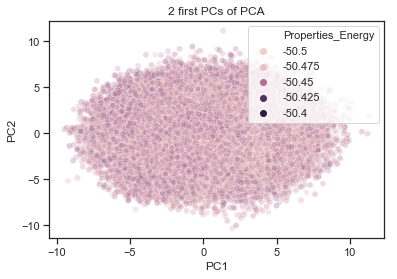

In [35]:
#2D graph of first two PCs
print('Explained variance PC1 :', pca.explained_variance_ratio_[0]*100, '%')
print('Explained variance PC2 :', pca.explained_variance_ratio_[1]*100, '%')

sns.scatterplot(x=PCs_df['PC1'], y=PCs_df['PC2'], hue=energy,  alpha=0.3)
plt.title("2 first PCs of PCA")
plt.ylabel('PC2')
plt.xlabel('PC1')
plt.show()

## K-means / Clustering
In order to reduce the variety of our observations we are clustering our data, by using a k-mean algorith.  
This algorithm is a non-hierarchical methods of clustering, i.e. we assume the number $ k $ of groups is assumed to be fixed.
Algorithm introduced by MacQueen (1967): each statistical unit is assigned to the cluster whose centroid (i.e. vector of means) is the closest one. The metric used to measure the distance among groups is typically the Euclidean one.

1. Initial partition into K clusters, (possibly randomly generated)
2. For each of the K clusters, compute the cluster centroid.
3. Assign each observation to the cluster whose centroid is closest
4. Recompute centroids for all clusters
5. Repeat 3. - 4. until reaching a maximum number of iterations or when it is not possible to redistribute observations

In order to chose the optimal number of groups, a good criteria is to find a balance between low within-cluster variation $WSS$ and number of groups.  
We start by clustering our original dataset, a clustering of the PCs dtaset is also shown.

In [44]:
kmeans = KMeans(n_clusters=4)  #we should choose the number of clusters
kmeans.fit(clusters_df)
energy_kmeans = kmeans.predict(clusters_df)

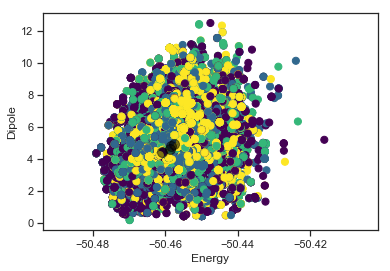

In [45]:
plt.scatter(clusters_df['Properties_Energy'], clusters_df['Properties_Dipole'], c=energy_kmeans,s=50, cmap='viridis')
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=100, alpha=0.5)
plt.xlabel('Energy')
plt.ylabel('Dipole')
plt.show()

> Can PCs and the energies be concat? Are they aligned still? $ \downarrow $

In [46]:
PCsE_df = pd.concat([PCs_df, clusters_df[['Properties_Energy']]], axis = 1)  
#finalDf = pd.concat([finalDf, clusters_df[['Properties_Dipole']]], axis = 1) # leave dipoles out

> Why do we concat them for clustering?  
Why not cluster only coordinates? What would it change?

In [47]:
#clustering using PCS as variables

kmeans.fit(PCsE_df)
PCE_kmeans = kmeans.predict(PCsE_df)

> So here change the comment $ \uparrow $ if we are using also energies

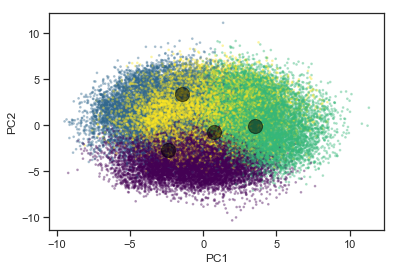

In [48]:
plt.scatter(PCsE_df['PC1'], PCsE_df['PC2'], c=PCE_kmeans,s=3, cmap='viridis', alpha=0.3)
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)
plt.ylabel('PC2')
plt.xlabel('PC1')
plt.show()

#### t-SNE for visualization

***

In [62]:
DF_embedded = TSNE(n_components=2).fit_transform(PCsE_df)

In [63]:
print(DF_embedded.shape)
print(type(DF_embedded))
print(DF_embedded[:5,:])

(46000, 2)
<class 'numpy.ndarray'>
[[-43.824703   -26.702303  ]
 [  0.57424843  54.7826    ]
 [-13.409994    21.275517  ]
 [ 14.46212      7.3965864 ]
 [  8.640952    18.475763  ]]


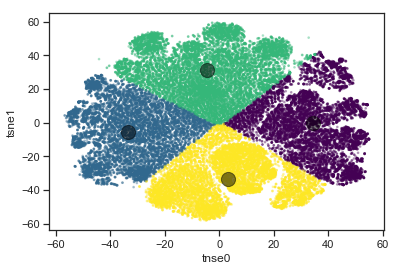

In [64]:
#clustering using PCS and energies as variables and t-SNE for visualization

kmeans.fit(DF_embedded)
y_kmeans = kmeans.predict(DF_embedded)
plt.scatter(DF_embedded[:,0],DF_embedded[:,1], c=y_kmeans,s=3, cmap='viridis', alpha=0.3)
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)
plt.ylabel('tsne1')
plt.xlabel('tnse0')
plt.show()

***

***

***

> The stuff forslecting the structures

```python
import numpy as np 
import sklearn.datasets, sklearn.decomposition 
 
X = sklearn.datasets.load_iris().data 
mu = np.mean(X, axis=0) 
 
pca = sklearn.decomposition.PCA() 
pca.fit(X) 
 
nComp = 2 
Xhat = np.dot(pca.transform(X)[:,:nComp], pca.components_[:nComp,:]) 
Xhat += mu 
 
print(Xhat[0,])

to determin the optimal k inmkmeans algo, we can choose the indicator that mazimize this index (Kalinkski and harabatz)

from sklearn import metrics 
from sklearn.metrics import pairwise_distances 
from sklearn import datasets 
dataset = finalDf 
X = dataset.data 
y = dataset.target 
import numpy as np 
from sklearn.cluster import KMeans 
kmeans_model = KMeans(n_clusters=3, random_state=1).fit(X) 
labels = kmeans_model.labels_ 
metrics.calinski_harabaz_score(X, labels) 
for k in range(2, 21): 
    kmeans_model = KMeans(n_clusters=k, random_state=1).fit(X) 
    labels = kmeans_model.labels_ 
    labels = kmeans_model.labels_ 
    print( k, metrics.calinski_harabaz_score(X, labels))
```


***

***

#### Variables in this notebook

> still under construction

| Variable             | Usage                    | Data type   |
| :------------------- | :----------------------- | :-----------|
| `clusters_df`        | Whole data               | DF          |
| `energy`             | energies col             | Series      |
| `coord`              | coordinate data          | DF          |
| `coord_train`        | x for training           | array       |
| `coord_test`         | x for testing            | array       |
| `energy_train`       | y for training           | array       |
| `energy_test`        | y for testing            | array       |
| `model`              | Linear Reg               | ***         |
| `r_sq`               | $ R^2 $-score            | float       |
| `energy_pred`        | predicted energies       | array       |
| `predictions`        | pred comparison          | DF          |
| `pca`                | PCA analysis             | pca         |
| `PCs_coord`          | PCs of coordinates       | array?      |
| `PCs_df`             | PCs of coordinates       | DF          |
| `energy_kmeans`      | K-means prediction       | array       |
| `PCsE_df`            | PCs and energies         | DF          |
| `PCE_kmeans`         | K-means pred from PCs    | array       |
| `DF_embedded`        | Stuff to t-SNE           | ???         |


***

***

***

***

***

***

***

In [ ]:
files = pd.read_csv("Data_Collection.csv")
np.array(files.Filename)

In [ ]:
test = next(files.iterrows())[1]
print(test)
type(test.Filename)

In [ ]:
xyz_test = pd.read_csv("Data1/coord/0.xyz", \
                       sep='\s+', \
                       skiprows=2, \
                       header=None, \
                       index_col=0, \
                       names=['x','y','z']\
                      ).sort_index(ascending=False)
# Atom names in indexes

```python
xyz_test = pd.read_csv("Data1/0.xyz", \
                       sep='\s+',\
                       skiprows=2, \
                       header=None, \
                       names=['atom','x','y','z']\
                      ).sort_values(by='atom',ascending=False).reset_index(drop=True)
# Atom names in col 0
```


Print the names of the atoms

> How is order handled under one label?
- what is the order of other coord files?

Save the names of the atoms to an array

In [ ]:
arr_indexes = np.array(xyz_test.index)

In [ ]:
arr_indexes.shape[0]

Get numbers for the atoms and concatenate them with the labels

In [ ]:
list_atomnames = []

for i,j in enumerate(arr_indexes):
    list_atomnames.append("{} {}".format(j,i))

arr_atomnames = np.array(list_atomnames)

Make the multi-index array of tuples

In [ ]:
top_arr = np.empty((arr_atomnames.size * 3)).astype(str)
top_arr[0::3] = arr_atomnames
top_arr[1::3] = arr_atomnames
top_arr[2::3] = arr_atomnames
#top_arr

In [ ]:
butt_arr = np.empty((arr_atomnames.size * 3)).astype(str)
butt_arr[0::3] = "x"
butt_arr[1::3] = "y"
butt_arr[2::3] = "z"
#butt_arr

In [ ]:
col_arr = np.vstack((top_arr,butt_arr))
#col_arr.transpose()
col_arr_tuples = list(zip(*col_arr))
col_arr_tuples[:5]

Multi-index column names

In [ ]:
col_names = pd.MultiIndex.from_tuples(col_arr_tuples, names=["Atom","Coord"])
col_names

In [ ]:
3*19

In [ ]:
xyz_test.values.flatten().shape

In [ ]:
xyz_flat = xyz_test.values.flatten().reshape(1,57)

In [ ]:
type(xyz_flat)

In [ ]:
coord_df = pd.DataFrame(xyz_flat,index=['a'],columns=col_names)
with pd.option_context('display.max_rows',None,'display.max_columns',None):
    print(coord_df)

In [ ]:
coord_df